## Pose Optimization with Differentable Rendering

### Imports

In [1]:
import os
from copy import deepcopy as dc
# math
import numpy as np
# graphics
import drjit as dr
import mitsuba as mi
from mitsuba.scalar_rgb import Transform4f as mit
# plots
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

# setup
mi.set_variant('llvm_ad_rgb')
print(f'Mitsuba 3 Variant: {mi.variant()}')

Mitsuba 3 Variant: llvm_ad_rgb


### Setup

In [2]:
#########
# Scene #
#########

# camera positioned to view the scene, adjust as needed
cam_pos = np.array([0.0, 1.0, 5.0])  
cam_target = np.array([0.0, 1.0, 0.0])
cam_up = np.array([0.0, 1.0, 0.0])

# particle
particle_init_pos = np.array([-0.5, 1.0, 0.0])
particle_rgb = np.array([0.2, 0.25, 0.7])

# target
target_pos = np.array([-2.0, 1.5, 0.0])

# optimization radiuses to try
fail_radius = 0.2
success_radius = 2.0

#############
# Rendering #
#############

img_width = 128
img_height = 128
fov = 60

render_integrator = {
    'type': 'direct_reparam',
}

img_scene_dict = {
    'type': 'scene',
    'integrator': render_integrator,
    'sensor':  {
        'type': 'perspective',
        'to_world': mit.look_at(
                        origin=cam_pos,
                        target=cam_target,
                        up=cam_up),
        'fov': fov,
        'film': {
            'type': 'hdrfilm',
            'width': img_width,
            'height': img_height,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
    },
    "light": {
        "type": "constant"
    },
    'particle': {
        'type': 'sphere',
        'center': particle_init_pos,
        'radius': success_radius,
        'bsdf': {'type': 'diffuse'}
    },
}


init_scene_dict = dict(img_scene_dict)
init_scene_dict['particle']['center'] = dc(particle_init_pos)
img_init = mi.render(mi.load_dict(init_scene_dict))

target_scene_dict = dict(img_scene_dict)
target_scene_dict['particle']['center'] = dc(target_pos)
img_ref = mi.render(mi.load_dict(target_scene_dict))

################
# Optimization #
################

def pose_apply_params(params, opt, init_state):
    #opt['trans'] = dr.clamp(opt['trans'], -0.5, 0.5)
    trafo = mi.Transform4f.translate([opt['trans'].x, opt['trans'].y, 0.0])

    params['particle.to_world'] = trafo @ init_state
    params.update()

    pose = params['particle.to_world']
    init_state
    return pose 

def pose_optim_params(scene, params, opt):
    # Perform a differentiable rendering
    img = mi.render(scene, params)

    # Evaluate the objective function
    loss = dr.sum(dr.sqr(img - img_ref)) / len(img)
    
    # Backpropagate through the rendering process
    dr.backward(loss)

    # Optimizer: take a gradient descent step
    opt.step()

    return loss

def ground_truth_loss(opt):
    true_trans = (target_pos - particle_init_pos)[:2]
    pred_trans = np.array([opt['trans'].x[0], opt['trans'].y[0]])
    return np.linalg.norm(true_trans - pred_trans)

### Optimization

In [3]:
train_iters = 100
train_rate = 0.02
train_save_interval = 5

scene_dict = dict(img_scene_dict)
scene_dict['particle']['center'] = dc(particle_init_pos)
scene = mi.load_dict(scene_dict)

params = mi.traverse(scene)
init_state = mi.Transform4f(params['particle.to_world'])

opt = mi.ad.Adam(lr=0.025)
opt['trans'] = mi.Point2f(0, 0)

trans_losses = []
img_losses = []
for i in range(train_iters):
    pose_apply_params(params, opt, init_state)
    loss = pose_optim_params(scene, params, opt)
    trans_loss = ground_truth_loss(opt) 
    img_losses.append(loss)
    trans_losses.append(trans_loss)
    if (i+1) % train_save_interval == 0:
        print(f"Iteration {i:02d}: img error={loss[0]:6f}, pose error={trans_loss:6f} trans=[{opt['trans'].x[0]:.4f}, {opt['trans'].y[0]:.4f}]")

Iteration 04: img error=0.064383, pose error=1.425454 trans=[-0.1248, 0.1250]
Iteration 09: img error=0.055138, pose error=1.277505 trans=[-0.2479, 0.2464]
Iteration 14: img error=0.047263, pose error=1.139984 trans=[-0.3688, 0.3585]
Iteration 19: img error=0.040928, pose error=1.013736 trans=[-0.4874, 0.4527]
Iteration 24: img error=0.035330, pose error=0.896513 trans=[-0.6036, 0.5122]
Iteration 29: img error=0.030471, pose error=0.784008 trans=[-0.7168, 0.5347]
Iteration 34: img error=0.025658, pose error=0.673455 trans=[-0.8270, 0.5257]
Iteration 39: img error=0.020962, pose error=0.564565 trans=[-0.9354, 0.4997]
Iteration 44: img error=0.016456, pose error=0.458307 trans=[-1.0423, 0.4756]
Iteration 49: img error=0.012332, pose error=0.354947 trans=[-1.1466, 0.4674]
Iteration 54: img error=0.008504, pose error=0.252412 trans=[-1.2483, 0.4805]
Iteration 59: img error=0.004942, pose error=0.151917 trans=[-1.3481, 0.4958]
Iteration 64: img error=0.001541, pose error=0.054708 trans=[-1.

### Results

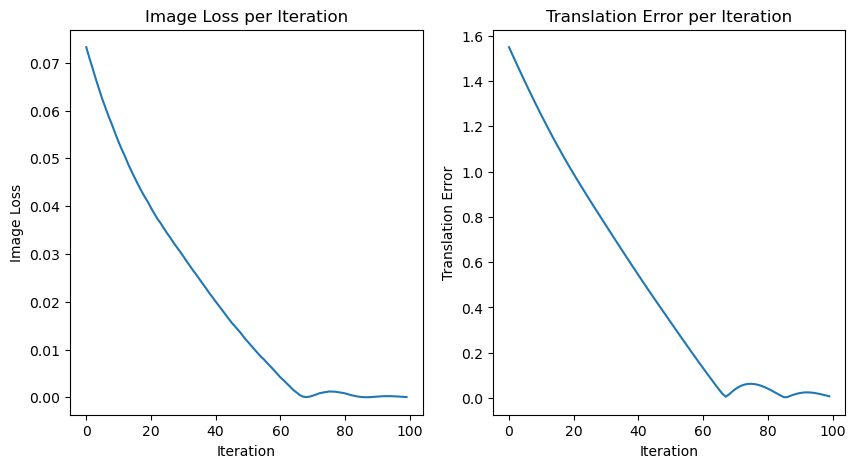

In [4]:
########
# Loss #
########
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].plot(img_losses)
axs[0].set_xlabel('Iteration'); 
axs[0].set_ylabel('Image Loss'); 
axs[0].set_title('Image Loss per Iteration');

axs[1].plot(trans_losses)
axs[1].set_xlabel('Iteration');
axs[1].set_ylabel('Translation Error'); 
axs[1].set_title('Translation Error per Iteration');

plt.show()

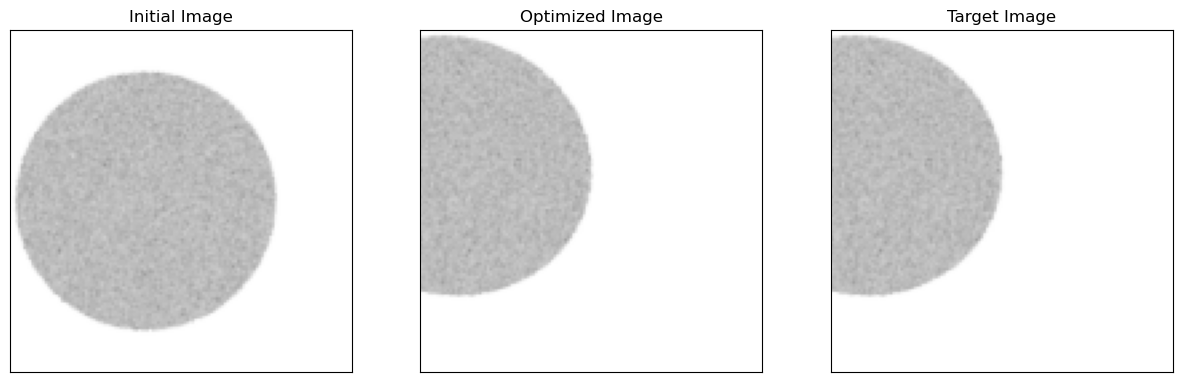

In [5]:
##########
# States #
##########
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(mi.util.convert_to_bitmap(img_init))
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[0].set_title('Initial Image')

axs[1].imshow(mi.util.convert_to_bitmap(mi.render(scene)))
axs[1].set_xticks([])
axs[1].set_yticks([])
axs[1].set_title('Optimized Image')

axs[2].imshow(mi.util.convert_to_bitmap(img_ref))
axs[2].set_xticks([])
axs[2].set_yticks([])
axs[2].set_title('Target Image')

plt.show()